In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/banglore-house-prices/Bengaluru_House_Data.csv


In [2]:
data = pd.read_csv("/kaggle/input/banglore-house-prices/Bengaluru_House_Data.csv")
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
missing_values = data[['location', 'size', 'total_sqft', 'bath', 'price']].isnull().sum()
unique_sizes = data['size'].unique()

missing_values, unique_sizes

(location       1
 size          16
 total_sqft     0
 bath          73
 price          0
 dtype: int64,
 array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
        '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
        '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
        '9 BHK', nan, '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
        '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
        '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object))

In [4]:
# Drop rows with missing values in 'location', 'size', or 'bath'
data_cleaned = data.dropna(subset=['location', 'size', 'bath'])

# Convert 'size' to a numeric feature by extracting the number before the space
data_cleaned['bhk'] = data_cleaned['size'].apply(lambda x: int(x.split(' ')[0]))

# Function to convert 'total_sqft' to numeric, handling ranges by taking the average
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None  # Returning None for non-convertible values

data_cleaned['total_sqft'] = data_cleaned['total_sqft'].apply(convert_sqft_to_num)

# Drop rows with None values in 'total_sqft' after conversion
data_cleaned = data_cleaned.dropna(subset=['total_sqft'])

data_cleaned['price_per_sqft'] = (data_cleaned['price']*100000 / data_cleaned['total_sqft'])
data_cleaned["location"] = data_cleaned["location"].apply(lambda x : x.strip())

# Check the cleaned dataset and missing values after cleaning
data_cleaned.shape

/tmp/ipykernel_13/3014282981.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['bhk'] = data_cleaned['size'].apply(lambda x: int(x.split(' ')[0]))
/tmp/ipykernel_13/3014282981.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['total_sqft'] = data_cleaned['total_sqft'].apply(convert_sqft_to_num)


(13200, 11)

In [5]:
def remove_outliers_sqft(df):
    newdf = pd.DataFrame()
    
    for key, subdf in df.groupby("location"):     #group every location to get a subdataframe
        m = np.mean(subdf.price_per_sqft)
        std = np.std(subdf.price_per_sqft)     #calculate mean and std of each subdataframe
        
        gendf = subdf[(subdf.price_per_sqft > (m-1.5*std)) & (subdf.price_per_sqft <= (m+1.5*std))]    
        #we only want to keep rows where price per sqft lies between m-std and m+std
        
        newdf = pd.concat([newdf, gendf], ignore_index = True)    #cncatenate the rows in output dataframe
    return newdf
    
data_cleaned = remove_outliers_sqft(data_cleaned)     
data_cleaned.shape

(11702, 11)

In [6]:
def remove_outliers_bhk(df):
    exclude_indices = np.array([])
    
    for location, location_df in df.groupby("location"):
        bhk_stats = {}
        
        for bhk, bhkdf in location_df.groupby("bhk"):     #for every type of bhk in every location
            
            bhk_stats[bhk] = {
                "mean": np.mean(bhkdf.price_per_sqft),     #calculate the mean, std, and number (count) of apartments
                "std": np.std(bhkdf.price_per_sqft),
                "count": bhkdf.shape[0]
            }
            
        for bhk, bhkdf in location_df.groupby("bhk"):
            stats = bhk_stats.get(bhk-1)      #for example, for 3 bhk, we need to see the stats of 2 bhk hence bhk-1 
            
            if stats and stats["count"] > 5:     #we only consider the stats if there are >5 data points to support it
                
                exclude_indices = np.append(exclude_indices, bhkdf[bhkdf.price_per_sqft < (stats["mean"])].index.values)
                #if price per sqft for 3 bhk is less than the mean of 2 bhk, add it to exclude indices
    
    return df.drop(exclude_indices, axis = "index")

data_cleaned = remove_outliers_bhk(data_cleaned)
data_cleaned.shape

(9523, 11)

In [7]:
data_cleaned.drop(columns = ["size", "price_per_sqft", "area_type", "availability", "society", "balcony"], inplace=True)
data_cleaned.head()

,location,total_sqft,bath,price,bhk
0,1st Block BEL Layout,1540.0,3.0,85.0,3
1,1st Block BEL Layout,1800.0,5.0,250.0,4
2,1st Block HBR Layout,2500.0,6.0,500.0,5
3,1st Block HBR Layout,600.0,1.0,45.0,1
4,1st Block HBR Layout,3150.0,4.0,150.0,4


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


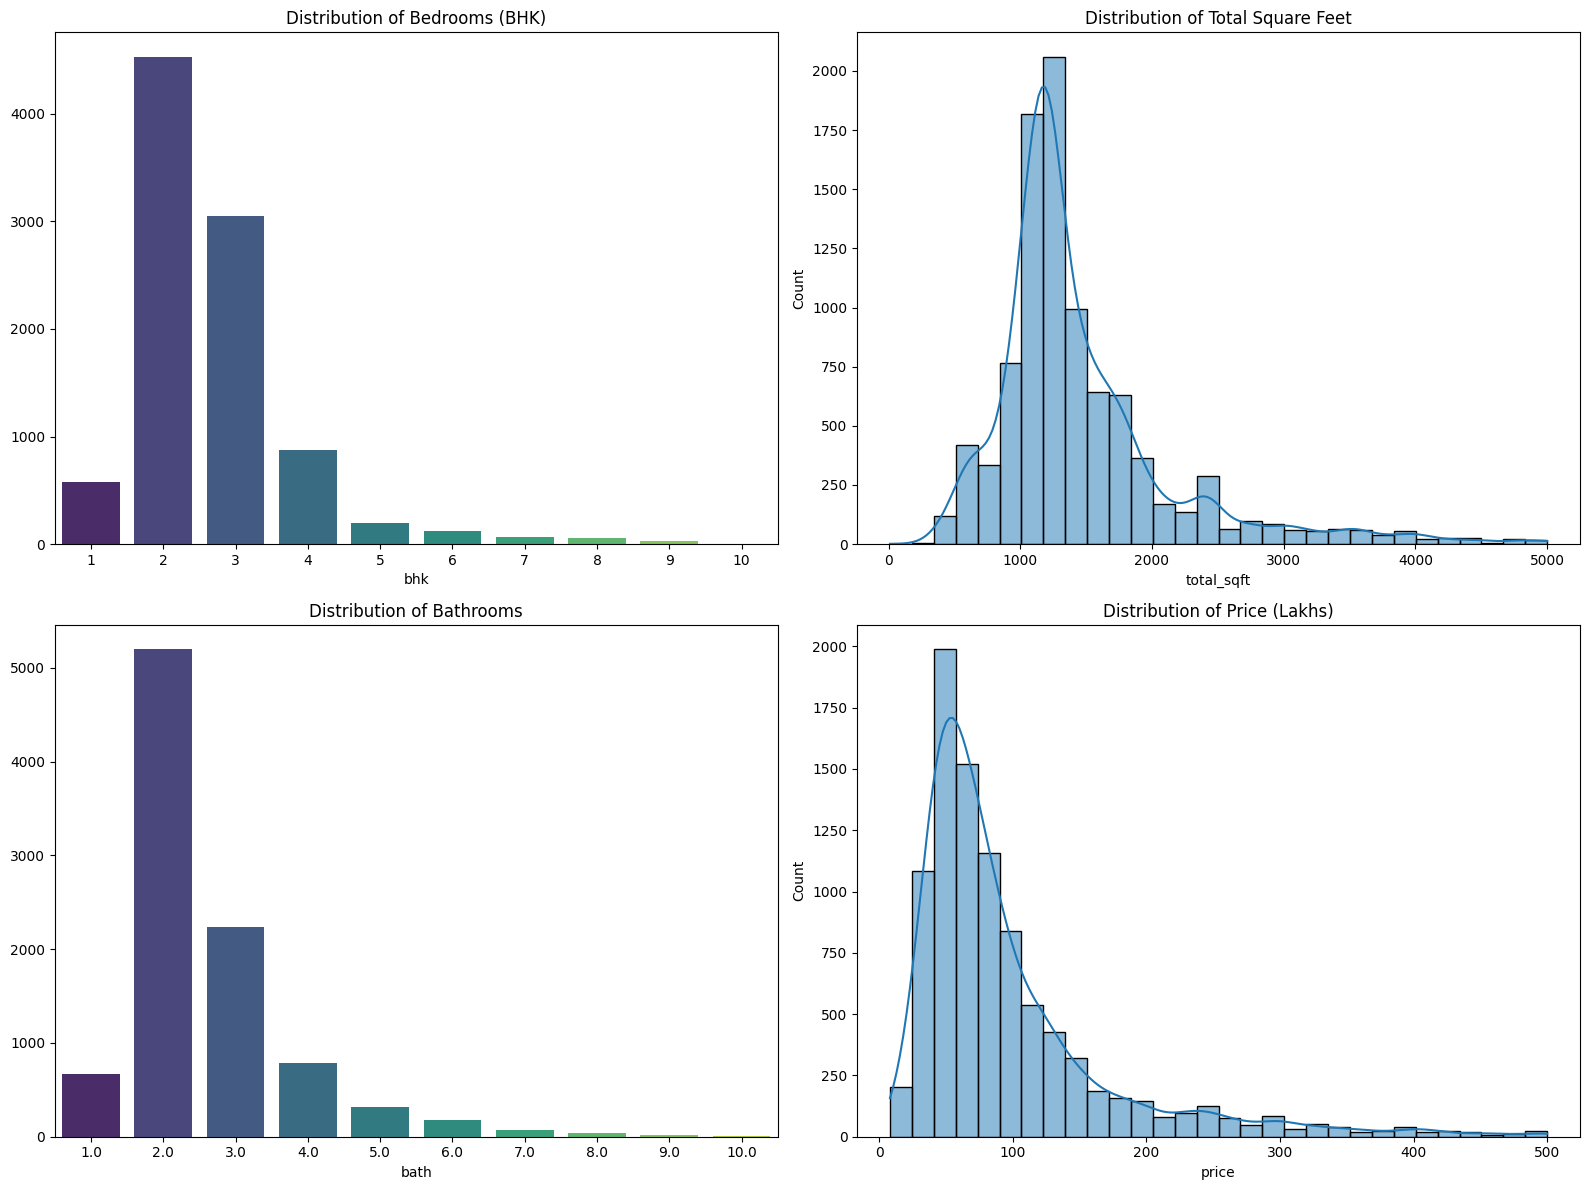

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Adjusting the plot distributions by limiting the x-axis to focus on the denser areas of the data
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Distribution of 'bhk' with a limited x-axis
bhk_counts = data_cleaned[data_cleaned['bhk'] <= 10]['bhk'].value_counts().sort_index()
sns.barplot(x=bhk_counts.index, y=bhk_counts.values, ax=ax[0, 0], palette='viridis')
ax[0, 0].set_title('Distribution of Bedrooms (BHK)')

# Distribution of 'total_sqft' with a limited x-axis
sns.histplot(data_cleaned[data_cleaned['total_sqft'] <= 5000]['total_sqft'], bins=30, kde=True, ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Total Square Feet')

# Distribution of 'bath' with a limited x-axis
bath_counts = data_cleaned[data_cleaned['bath'] <= 10]['bath'].value_counts().sort_index()
sns.barplot(x=bath_counts.index, y=bath_counts.values, ax=ax[1, 0], palette='viridis')
ax[1, 0].set_title('Distribution of Bathrooms')

# Distribution of 'price' with a limited x-axis
sns.histplot(data_cleaned[data_cleaned['price'] <= 500]['price'], bins=30, kde=True, ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Price (Lakhs)')

plt.tight_layout()
plt.savefig("dist.png")
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# One-hot encode 'location' and prepare features and target variable
X = data_cleaned[['location', 'bhk', 'total_sqft', 'bath']]
y = data_cleaned['price']

# Define the preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['bhk', 'total_sqft', 'bath']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['location']),
    ])

# Create the regression model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(6197.818314646622, 0.6038017028368051)

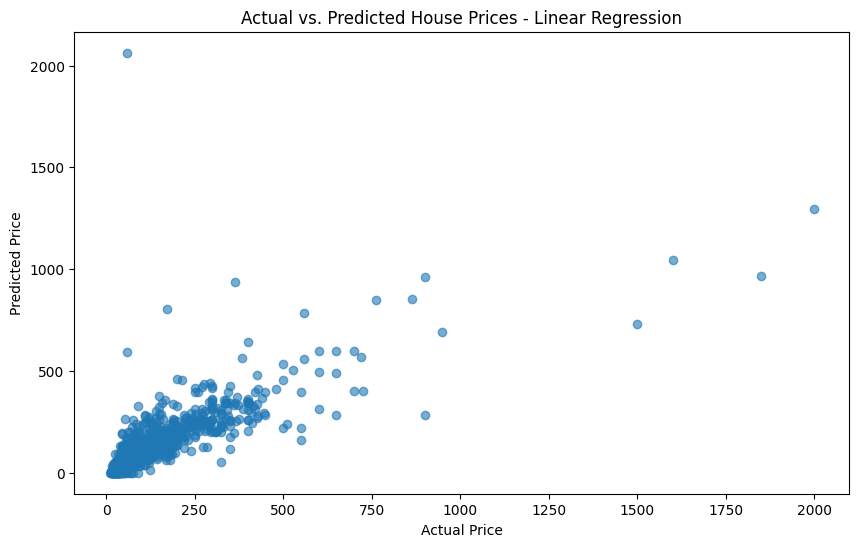

In [10]:
# Plotting forecasted values against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()]) # Diagonal line for reference
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted House Prices - Linear Regression')
plt.savefig('Regression')
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preparing the data for modeling
X = data_cleaned[['location', 'bhk', 'total_sqft', 'bath']]
y = data_cleaned['price']

# Encoding categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['bhk', 'total_sqft', 'bath']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['location']),
    ])

# Define the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LGBMRegressor())])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 466
[LightGBM] [Info] Number of data points in the train set: 7618, number of used features: 96
[LightGBM] [Info] Start training from score 108.357768


(3797.380358912727, 0.7572507686572987)

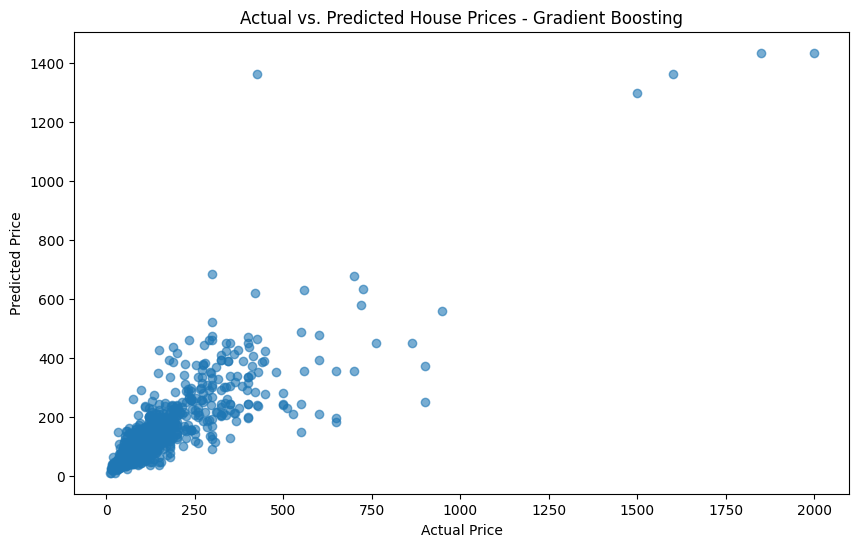

In [12]:
# Plotting forecasted values against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()]) # Diagonal line for reference
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted House Prices - Gradient Boosting')
plt.savefig('Gradient Boosting')
plt.show()

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Redefine the model to use Random Forest Regressor
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

# Fit the model
model_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = model_rf.predict(X_test)
y_pred_rf[y_pred_rf < 0] = 0

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, r2_rf

(2942.4306255930924, 0.8119038112772936)

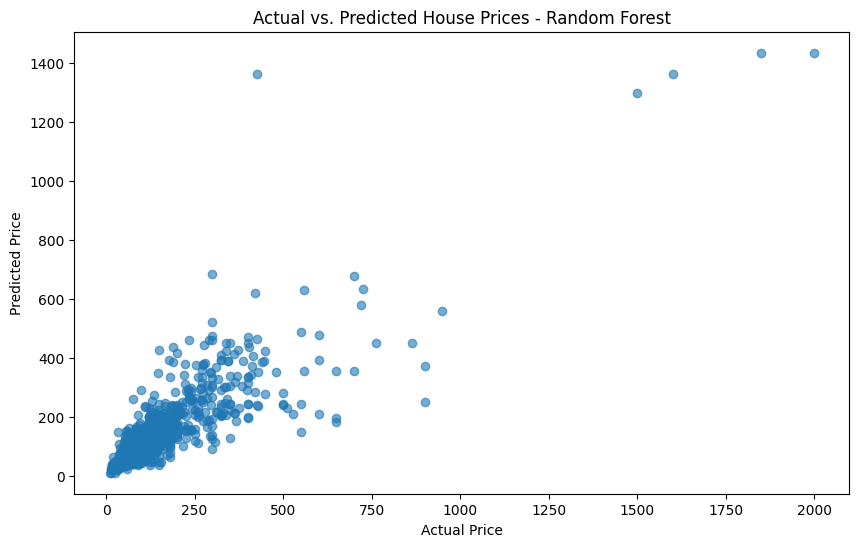

In [14]:
# Plotting forecasted values against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()]) # Diagonal line for reference
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted House Prices - Random Forest')
plt.savefig('Random Forest')
plt.show()